In [1]:
import numpy as np

from lightonml.projections.sklearn import OPUMap
from lightonopu.opu import OPU
import time 
import os
from sklearn.linear_model import RidgeClassifier
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
import math

import h5py

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

### load data

In [ ]:
#train_random_features = np.load("train_random_features.npy")
#test_random_features = np.load("test_random_features.npy")

#y_train_bin = np.load("labels_train.npy")
#y_test_bin = np.load("labels_test.npy")

In [ ]:
#train_features_tofloat = torch.from_numpy(train_random_features).float()
#train_label_tofloat = torch.from_numpy(y_train_bin).float()

#test_features_tofloat = torch.from_numpy(test_random_features).float()
#test_label_tofloat = torch.from_numpy(y_test_bin).float()

In [2]:
f_train = h5py.File("train_random_features.h5", 'r')
f_test = h5py.File("test_random_features.h5",'r')

In [3]:
train_random_features = f_train['inputs'][:200000,:40000]
y_train_bin = f_train['labels'][:200000]

test_random_features = f_test['inputs'][:,:40000]
y_test_bin = f_test['labels'][:]

In [4]:
train_random_features.shape

(200000, 40000)

In [5]:
y_train_bin.shape

(200000, 1)

### Scale random features

In [6]:
min_max = preprocessing.MinMaxScaler()
min_max.fit(train_random_features[:10000])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [7]:
for i in range(train_random_features.shape[0]):
    train_random_features[i] = min_max.transform(train_random_features[i:i+1])

In [8]:
for i in range (test_random_features.shape[0]):
    test_random_features[i] = min_max.transform(test_random_features[i:i+1])

In [ ]:
#train_random_features = np.sqrt(train_random_features)
#test_random_features = np.sqrt(test_random_features)

## Train model

In [9]:
batch_size = 1024
dataset_train = TensorDataset( torch.Tensor(train_random_features), torch.Tensor(y_train_bin) )
data_loader_train = DataLoader(dataset_train,batch_size=batch_size,shuffle=True)
#data_loader_test = DataLoader((test_random_features,test_label_tofloat),batch_size=batch_size,shuffle=False)

In [10]:
n_components = 40000
model = nn.Linear(n_components, 1)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, weight_decay = .1)

for num_epochs in range(20):
    counter = 0
    for inp, lbl in data_loader_train:
        model.train()
        logits = model(inp)
        loss = criterion(logits, lbl)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if(counter%10 == 0):
            print('epoch {}, loss {}'.format(num_epochs+1, loss.item()))
        counter = counter+1

epoch 1, loss 0.42145833373069763
epoch 1, loss 0.4106537401676178
epoch 1, loss 0.3719385266304016
epoch 1, loss 0.3627423048019409
epoch 1, loss 0.34111374616622925
epoch 1, loss 0.339495450258255
epoch 1, loss 0.3292670249938965
epoch 1, loss 0.3070109188556671
epoch 1, loss 0.32036271691322327
epoch 1, loss 0.28640493750572205
epoch 1, loss 0.2887895107269287
epoch 1, loss 0.3044669032096863
epoch 1, loss 0.2784475088119507
epoch 1, loss 0.2856264114379883
epoch 1, loss 0.27382469177246094
epoch 1, loss 0.27393656969070435
epoch 1, loss 0.2668074369430542
epoch 1, loss 0.271474152803421
epoch 1, loss 0.2615140676498413
epoch 1, loss 0.26784810423851013
epoch 2, loss 0.25422757863998413
epoch 2, loss 0.2523675262928009
epoch 2, loss 0.2594686448574066
epoch 2, loss 0.25744086503982544
epoch 2, loss 0.25553449988365173
epoch 2, loss 0.25258874893188477
epoch 2, loss 0.2599264681339264
epoch 2, loss 0.2577853798866272
epoch 2, loss 0.2576011121273041
epoch 2, loss 0.24888379871845245


epoch 13, loss 0.2475593239068985
epoch 13, loss 0.2416159212589264
epoch 13, loss 0.2401168793439865
epoch 13, loss 0.24570614099502563
epoch 13, loss 0.2481706738471985
epoch 13, loss 0.24338307976722717
epoch 13, loss 0.25034305453300476
epoch 13, loss 0.24332553148269653
epoch 13, loss 0.24558991193771362
epoch 13, loss 0.25186416506767273
epoch 13, loss 0.24331337213516235
epoch 13, loss 0.24924276769161224
epoch 13, loss 0.24410583078861237
epoch 13, loss 0.25301894545555115
epoch 13, loss 0.2447119653224945
epoch 13, loss 0.24748387932777405
epoch 13, loss 0.24156393110752106
epoch 14, loss 0.2440253347158432
epoch 14, loss 0.24778465926647186
epoch 14, loss 0.24966447055339813
epoch 14, loss 0.23910297453403473
epoch 14, loss 0.24347727000713348
epoch 14, loss 0.2444058060646057
epoch 14, loss 0.24704141914844513
epoch 14, loss 0.25101184844970703
epoch 14, loss 0.2440553605556488
epoch 14, loss 0.24914692342281342
epoch 14, loss 0.24414192140102386
epoch 14, loss 0.24533224105

In [11]:
model.eval()
y_output = model(torch.Tensor(test_random_features))
test_output_sgd = np.array(y_output.detach())

In [12]:
fpr_opu, tpr_opu, thresholds = metrics.roc_curve(y_test_bin,test_output_sgd)
metrics.auc(fpr_opu, tpr_opu)

0.5250230912335423

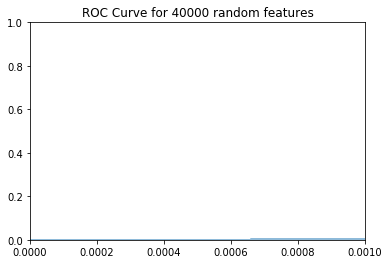

In [13]:
pyplot.plot(fpr_opu, tpr_opu, lw=2,alpha=0.5)
pyplot.axis((0,.001,0,1))
pyplot.title("ROC Curve for 40000 random features")
pyplot.savefig("ROC Curve 40000 on OPU (SGD on 200000 images)")

## Interpret Output

In [14]:
train_scores = []
for i in range(train_random_features.shape[0]):
    train_scores.append(np.array(model(torch.Tensor(train_random_features[i:i+1])).detach()[0]))

In [15]:
minMax = preprocessing.MinMaxScaler()
minMax.fit(train_scores)
train_scores = minMax.transform(train_scores)
test_scores = np.array(y_output.detach())
test_scores = minMax.transform(test_scores)

In [16]:
def compare_train_test(y_pred_train, y_train, y_pred, y_test, high_low=(0,1), bins=30):
    pyplot.hist(y_pred_train[y_train == 1],
                 color='r', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=True,
                 label='S (train)') # alpha is transparancy
    pyplot.hist(y_pred_train[y_train == 0],
                 color='b', alpha=0.5, range=high_low, bins=bins,
                 histtype='stepfilled', density=True,
                 label='B (train)')

    hist, bins = np.histogram(y_pred[y_test == 1], bins=bins, range=high_low, 
                                   density=True)
    scale = len(y_pred[y_test == 1]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    pyplot.errorbar(center, hist, yerr=err, fmt='o', c='r', label='S (test)')

    hist, bins = np.histogram(y_pred[y_test == 0],
                                  bins=bins, range=high_low, density=True)
    scale = len(y_pred[y_test == 0]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    #width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    pyplot.errorbar(center, hist, yerr=err, fmt='o', c='b', label='B (test)')
    pyplot.xlabel("SGD scores for 40000 random featues and 20 epochs")
    pyplot.ylabel("Arbitrary units")
    pyplot.legend(loc='best')
    
    pyplot.savefig("SGD 20 epochs-40000 features")

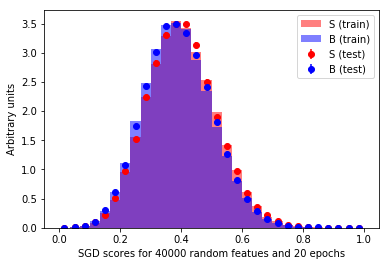

In [17]:
compare_train_test(train_scores,y_train_bin,test_scores,y_test_bin)